## Credit Card Fraud Detection

In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

plt.rcParams['figure.figsize'] = (15, 10)

import warnings
warnings.filterwarnings("ignore")

In [64]:
df = pd.read_csv('credit_card_data.csv')

In [65]:
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


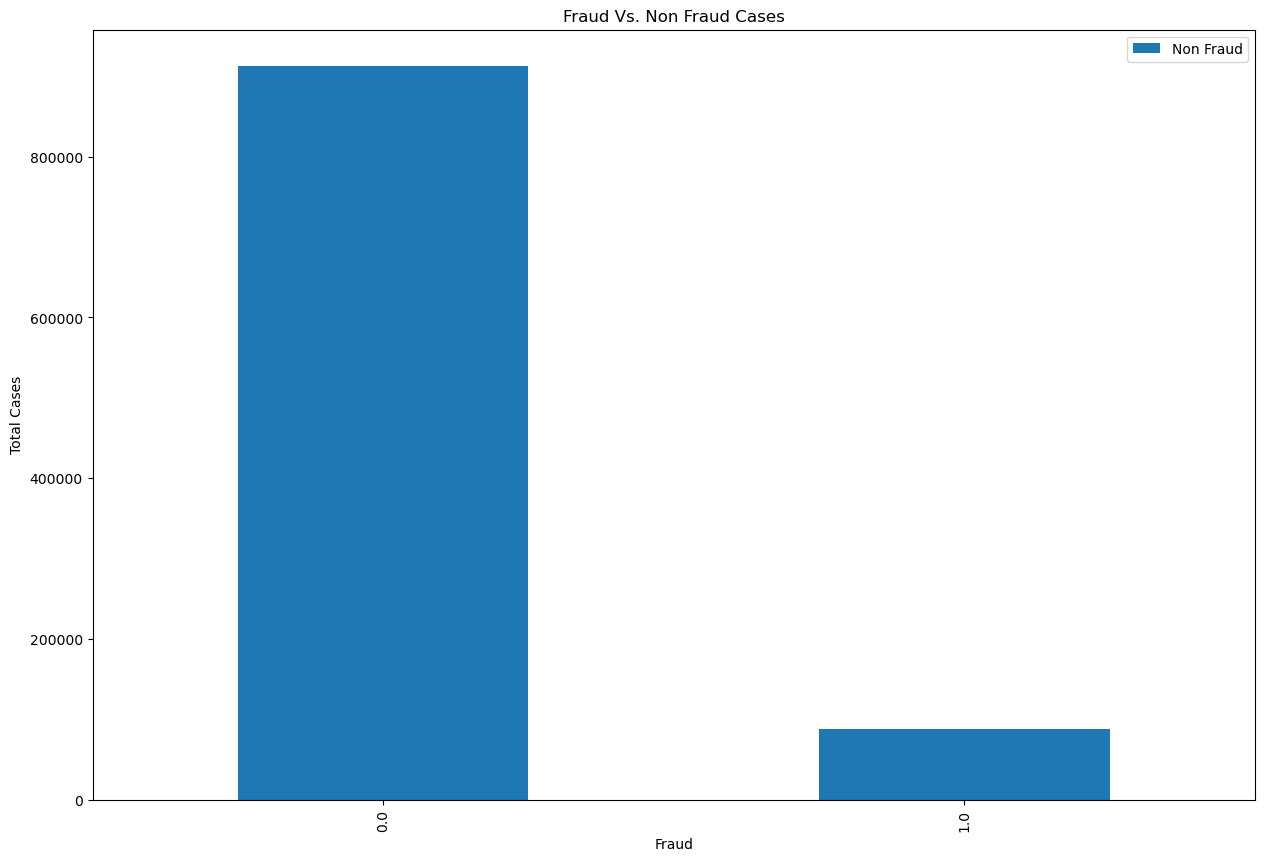

In [67]:
df['fraud'].value_counts().plot(kind = 'bar')
plt.title("Fraud Vs. Non Fraud Cases")
plt.xlabel("Fraud")
plt.ylabel("Total Cases")
plt.legend(['Non Fraud', 'Fraud'])
plt.show()

In [68]:
X = df.drop(['fraud'], axis = 1)
y = df['fraud'].values.reshape(-1, 1)

In [69]:
print("The shape of the input data: {}".format(X.shape))
print("The shape of the output data: {}".format(y.shape))

The shape of the input data: (1000000, 7)
The shape of the output data: (1000000, 1)


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101,
                                                   stratify = y)

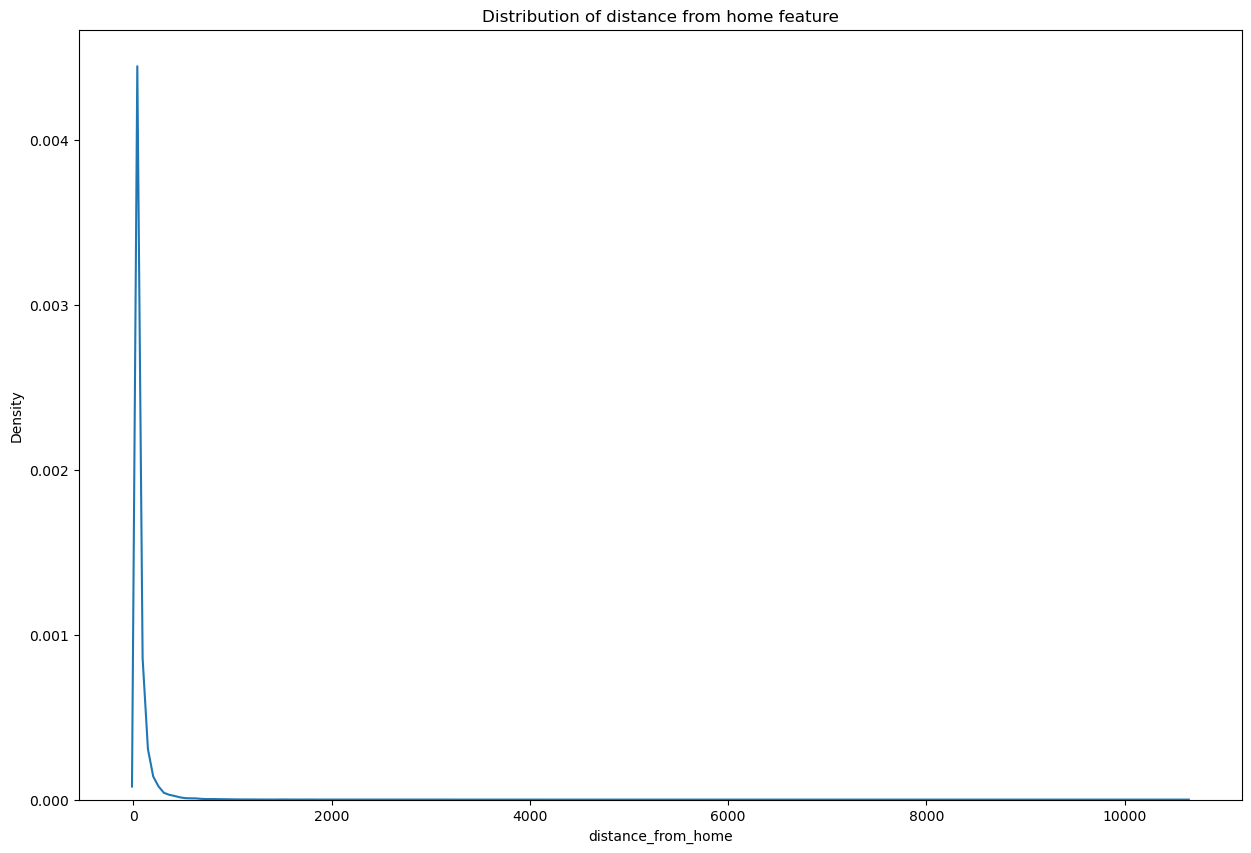

In [71]:
sns.kdeplot(X_train['distance_from_home'])
plt.title("Distribution of distance from home feature")
plt.show()

In [72]:
fraud_cases = df[df['fraud'] == 1]
non_fraud_cases = df[df['fraud'] == 0]

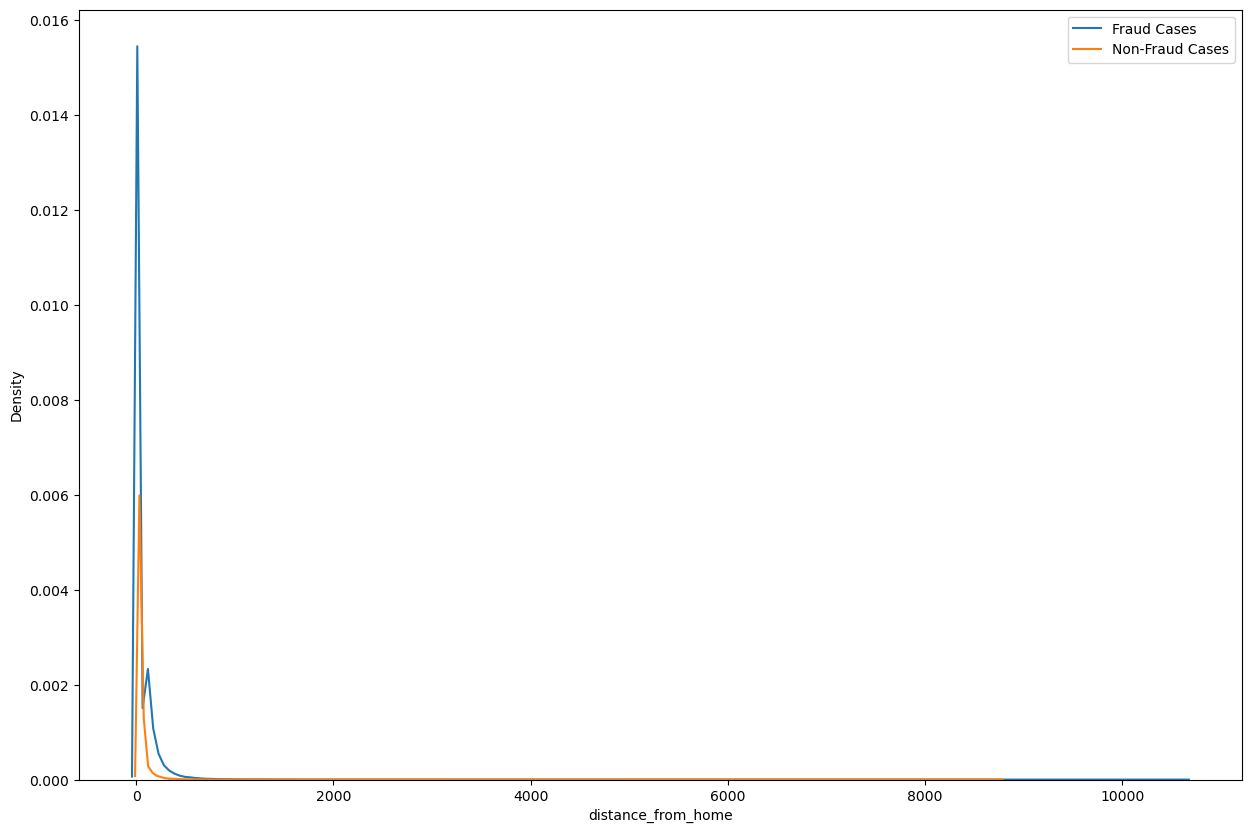

In [73]:
sns.kdeplot(fraud_cases['distance_from_home'], label = "Fraud Cases")
sns.kdeplot(non_fraud_cases['distance_from_home'], label = "Non-Fraud Cases")
plt.legend()
plt.show()

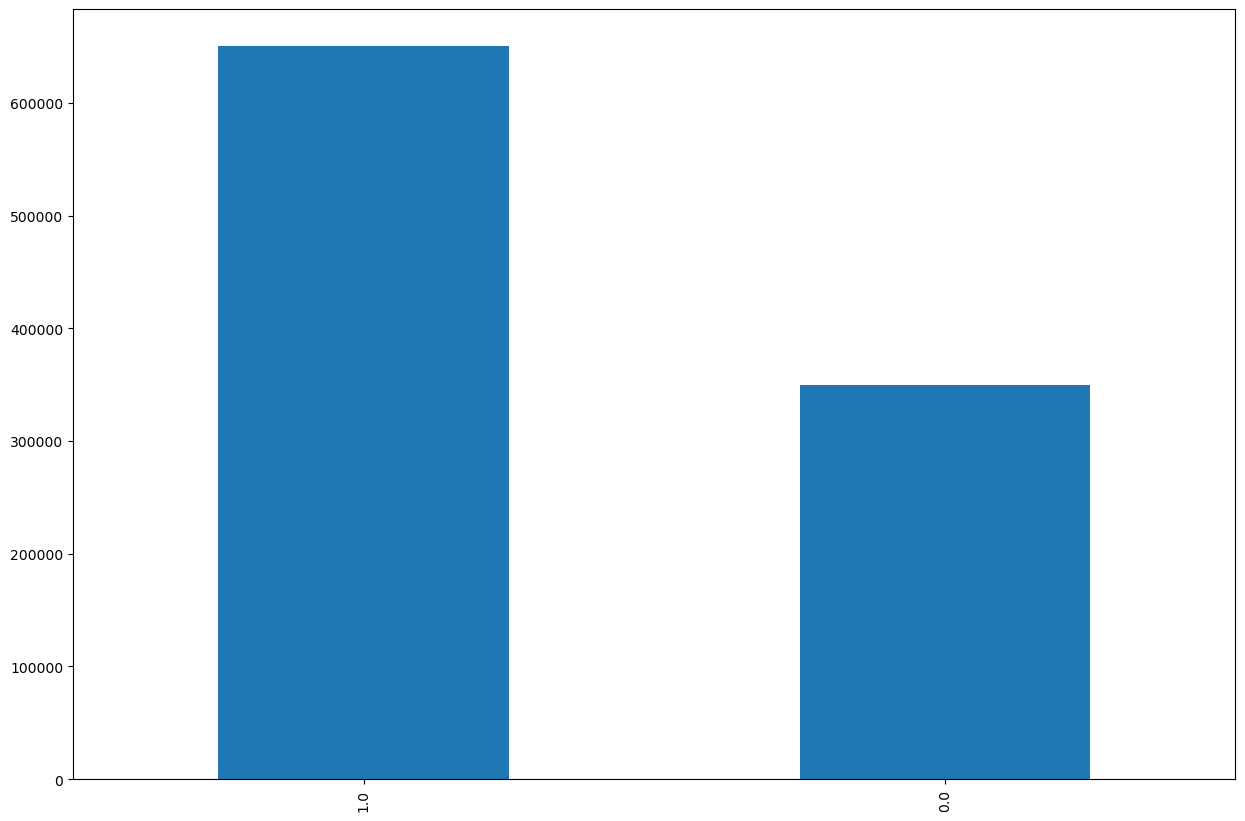

In [74]:
df['online_order'].value_counts().plot(kind = 'bar')
plt.show()

<AxesSubplot: >

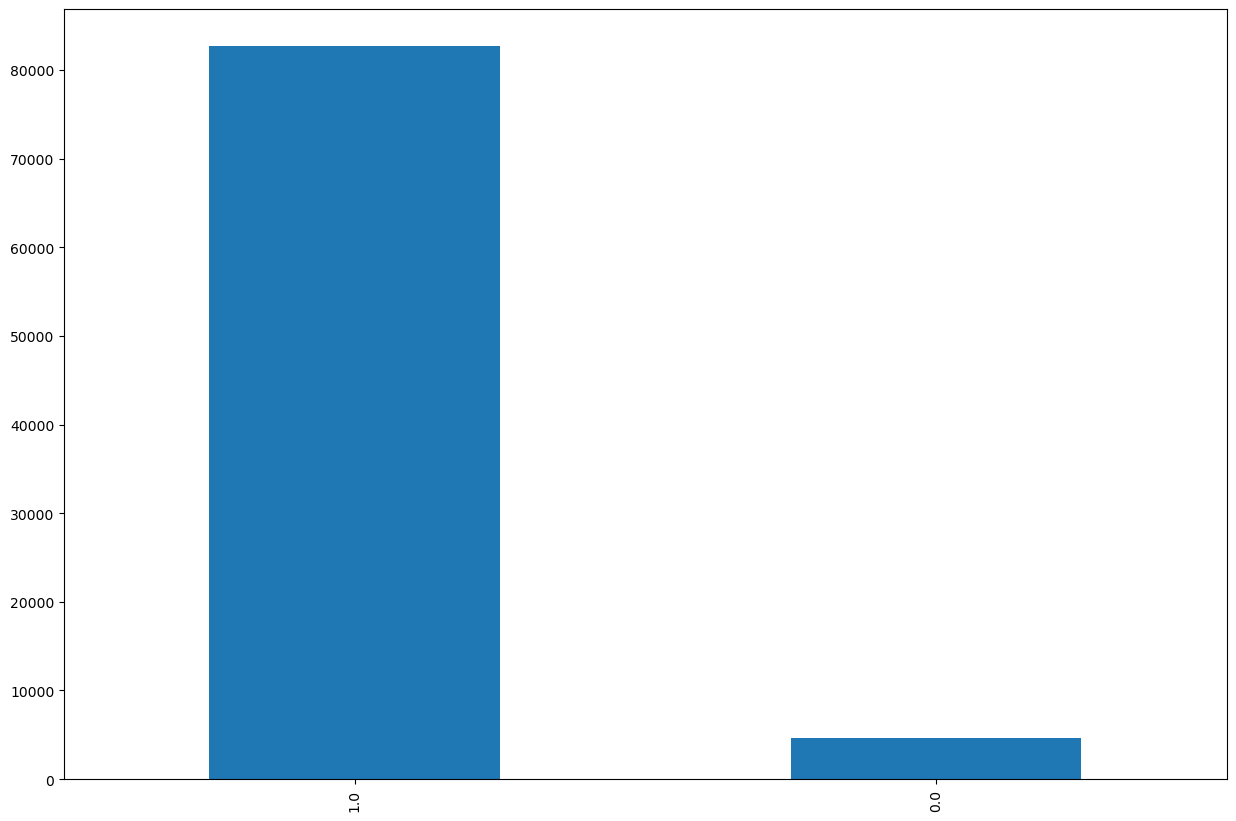

In [75]:
fraud_cases['online_order'].value_counts().plot(kind = 'bar')

<AxesSubplot: >

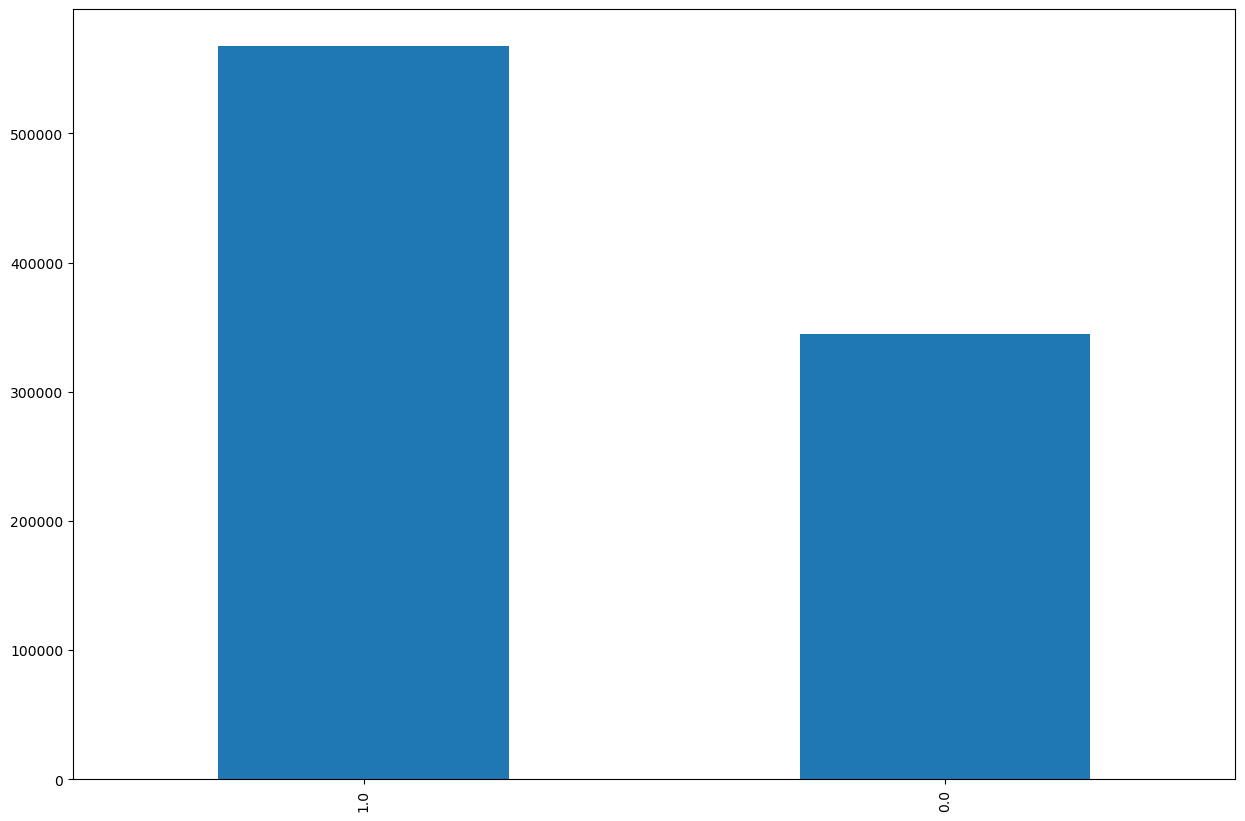

In [76]:
non_fraud_cases['online_order'].value_counts().plot(kind = 'bar')

<AxesSubplot: >

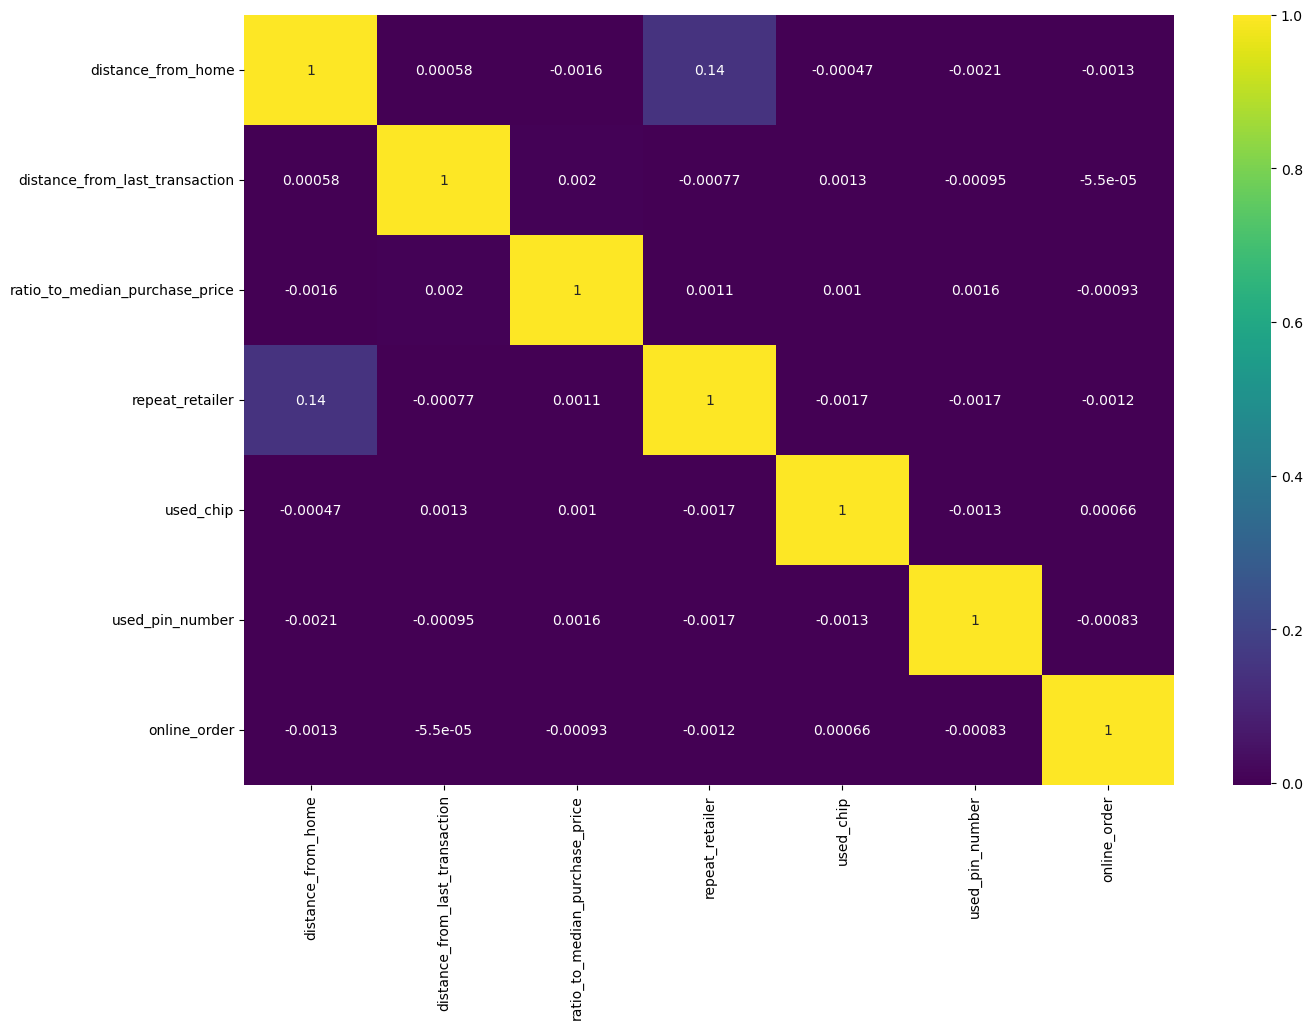

In [77]:
sns.heatmap(X_train.corr(), annot = True, cmap = 'viridis')

In [78]:
X_train.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
74182,7.000075,16.595474,0.664250,1.0,0.0,0.0,1.0
196318,1.477599,0.071672,2.424212,0.0,1.0,0.0,0.0
925685,4.515377,1.795108,0.116781,1.0,0.0,0.0,1.0
728002,10.586309,0.229630,3.049301,1.0,0.0,1.0,1.0
875280,17.360498,0.088579,0.267554,1.0,0.0,0.0,0.0


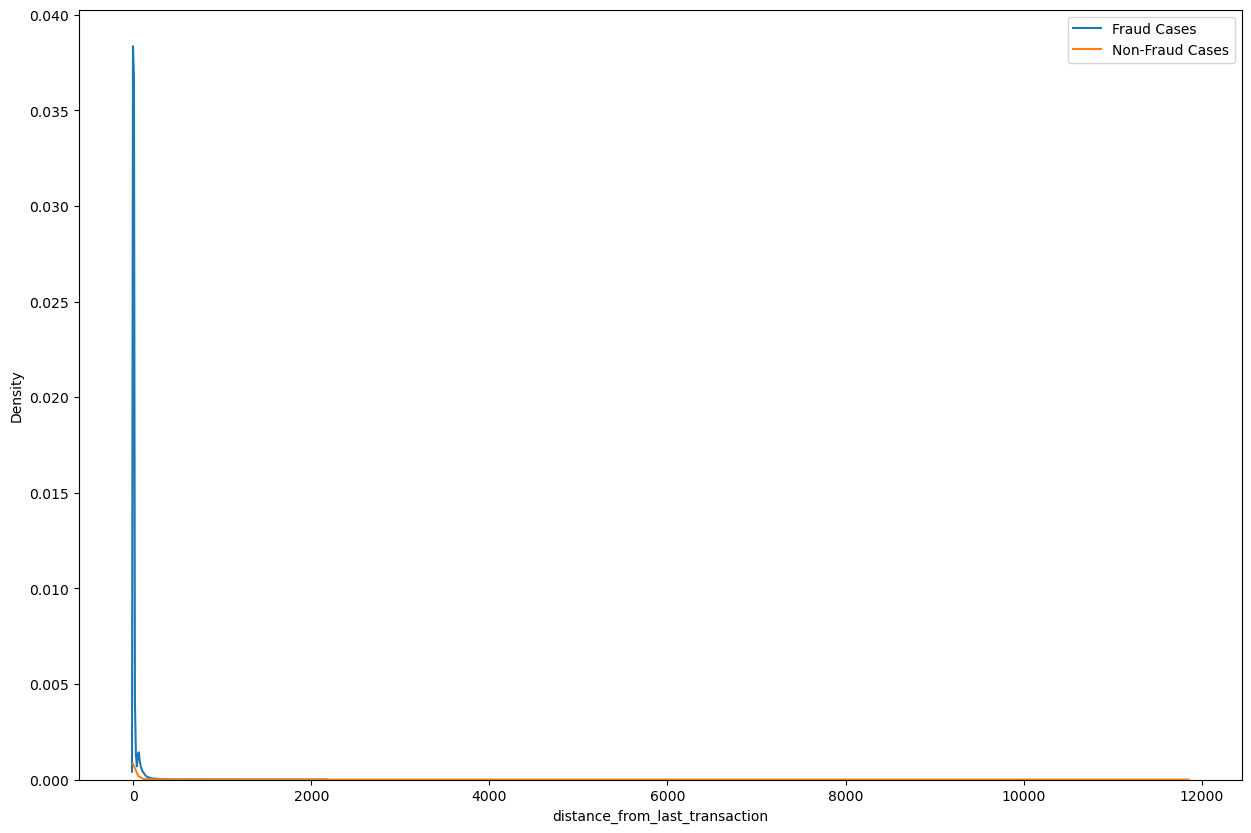

In [79]:
sns.kdeplot(fraud_cases['distance_from_last_transaction'], label = "Fraud Cases")
sns.kdeplot(non_fraud_cases['distance_from_last_transaction'], label = "Non-Fraud Cases")
plt.legend()
plt.show()

### Training an ML Model

In [80]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

In [81]:
X_train_dropped = X_train.drop(['ratio_to_median_purchase_price'], axis = 1)
X_test_dropped = X_test.drop(['ratio_to_median_purchase_price'], axis = 1)

In [82]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_dropped, y_train)

[11:12:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [83]:
X_test.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
902092,5.678337,5.217001,6.063064,1.0,0.0,0.0,1.0
466758,53.338851,0.246248,0.863431,1.0,1.0,0.0,1.0
653474,2.019088,0.057677,0.819675,1.0,0.0,0.0,1.0
488200,5.618768,0.166979,6.216503,1.0,0.0,0.0,0.0
673306,1.060857,5.847861,1.368737,0.0,0.0,0.0,1.0


In [84]:
y_predictions = xgb_model.predict(X_test_dropped)

In [85]:
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97    273779
         1.0       1.00      0.28      0.44     26221

    accuracy                           0.94    300000
   macro avg       0.97      0.64      0.70    300000
weighted avg       0.94      0.94      0.92    300000



In [86]:
confusion_matrix(y_test, y_predictions)

array([[273770,      9],
       [ 18777,   7444]], dtype=int64)

### Feature Importance

In [87]:
import shap

In [88]:
explainer = shap.Explainer(xgb_model)

In [89]:
explainer

In [91]:
shap_values = explainer(X_train_dropped)

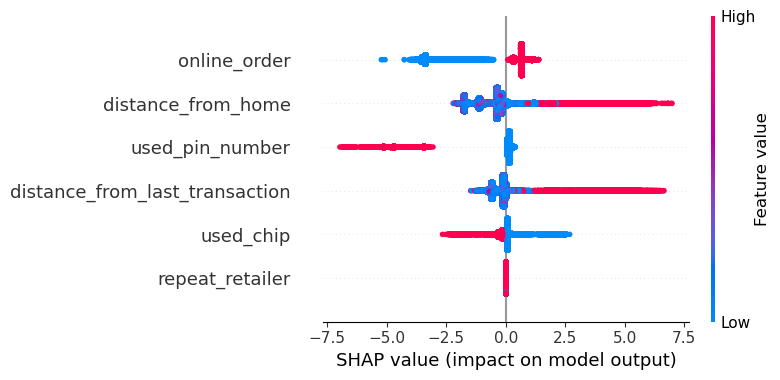

In [92]:
shap.summary_plot(shap_values, X_train_dropped)

<AxesSubplot: xlabel='ratio_to_median_purchase_price', ylabel='Density'>

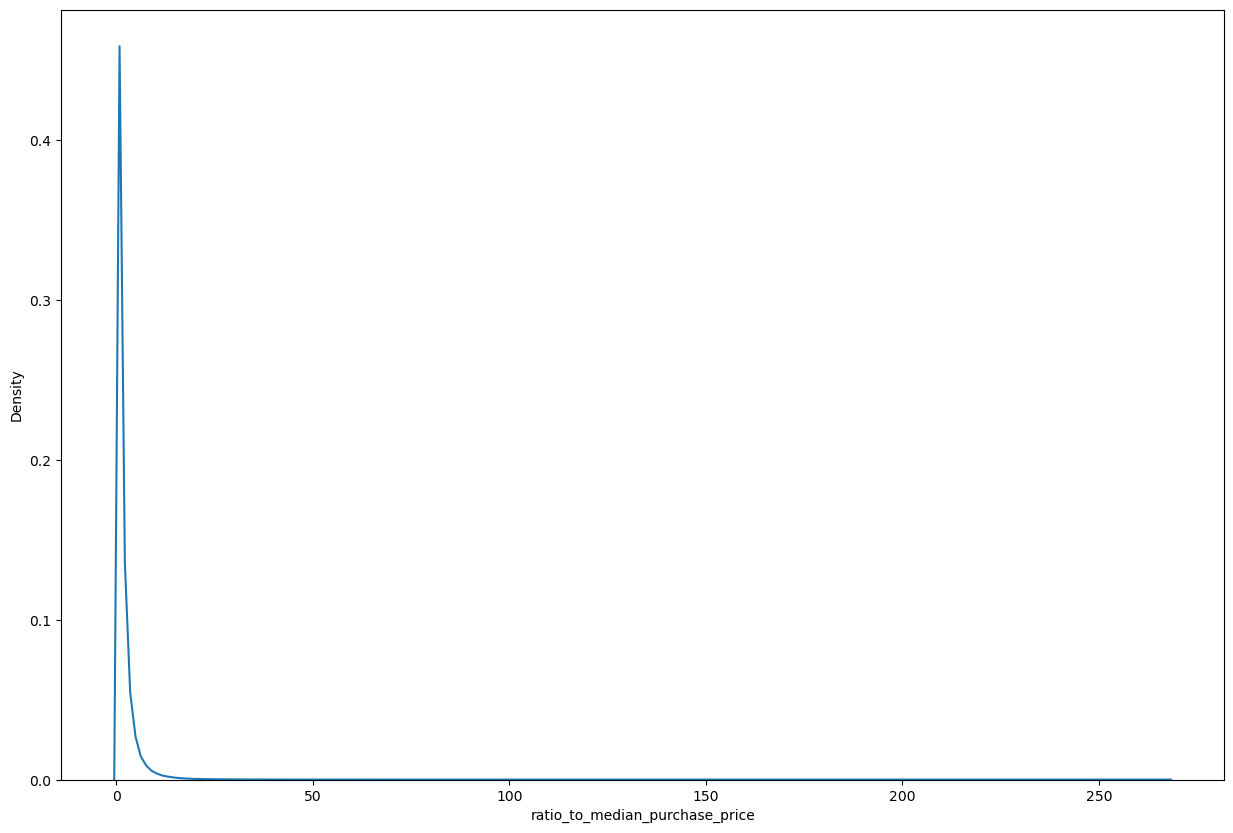

In [93]:
sns.kdeplot(X_train['ratio_to_median_purchase_price'])

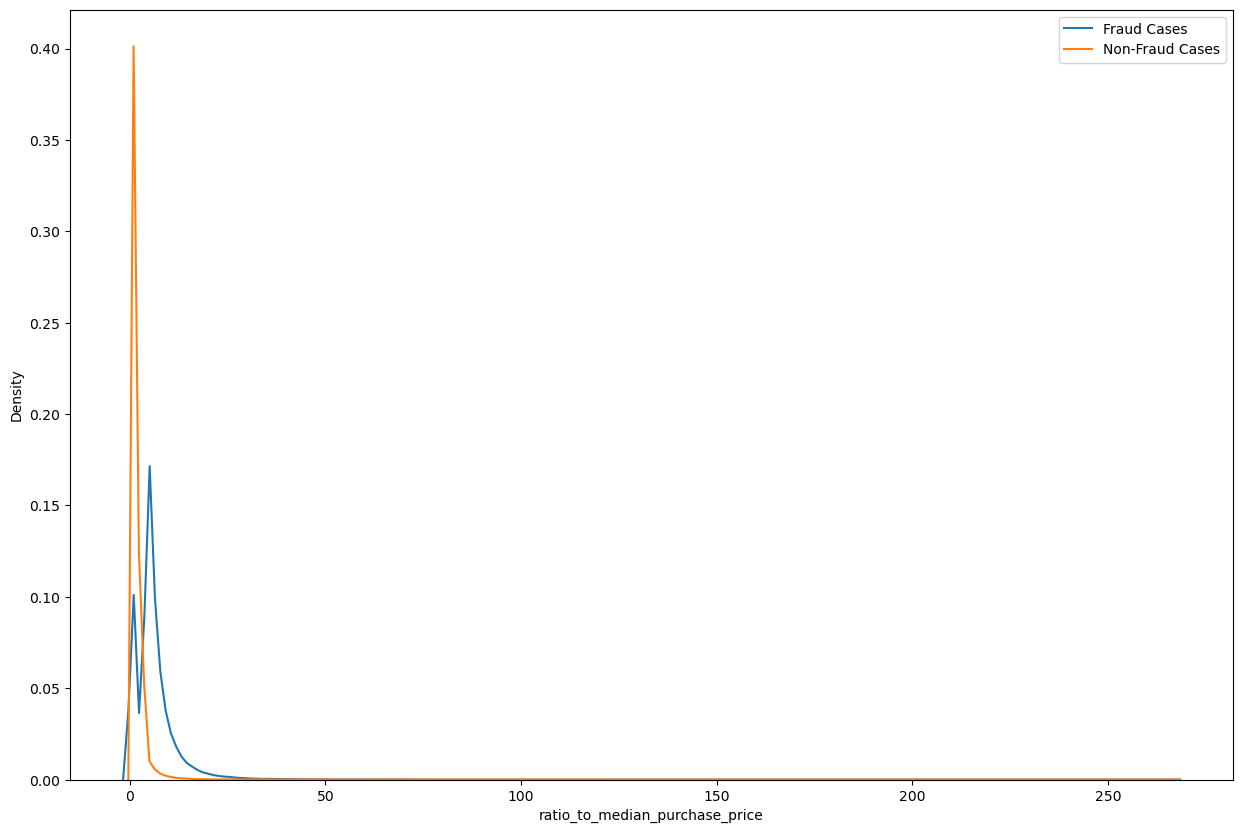

In [94]:
sns.kdeplot(fraud_cases['ratio_to_median_purchase_price'], label = "Fraud Cases")
sns.kdeplot(non_fraud_cases['ratio_to_median_purchase_price'], label = "Non-Fraud Cases")
plt.legend()
plt.show()

### Training an ML Model with Feature Engineering

### Scaling

In [95]:
from sklearn.preprocessing import StandardScaler

In [96]:
X_train.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
74182,7.000075,16.595474,0.664250,1.0,0.0,0.0,1.0
196318,1.477599,0.071672,2.424212,0.0,1.0,0.0,0.0
925685,4.515377,1.795108,0.116781,1.0,0.0,0.0,1.0
728002,10.586309,0.229630,3.049301,1.0,0.0,1.0,1.0
875280,17.360498,0.088579,0.267554,1.0,0.0,0.0,0.0


In [97]:
X_test.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
902092,5.678337,5.217001,6.063064,1.0,0.0,0.0,1.0
466758,53.338851,0.246248,0.863431,1.0,1.0,0.0,1.0
653474,2.019088,0.057677,0.819675,1.0,0.0,0.0,1.0
488200,5.618768,0.166979,6.216503,1.0,0.0,0.0,0.0
673306,1.060857,5.847861,1.368737,0.0,0.0,0.0,1.0


In [98]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_dropped)
X_test_scaled = scaler.transform(X_test_dropped)

In [99]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_scaled, y_train)

[11:15:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [100]:
y_predictions = xgb_model.predict(X_test_scaled)

In [101]:
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97    273779
         1.0       1.00      0.28      0.44     26221

    accuracy                           0.94    300000
   macro avg       0.97      0.64      0.70    300000
weighted avg       0.94      0.94      0.92    300000



<AxesSubplot: >

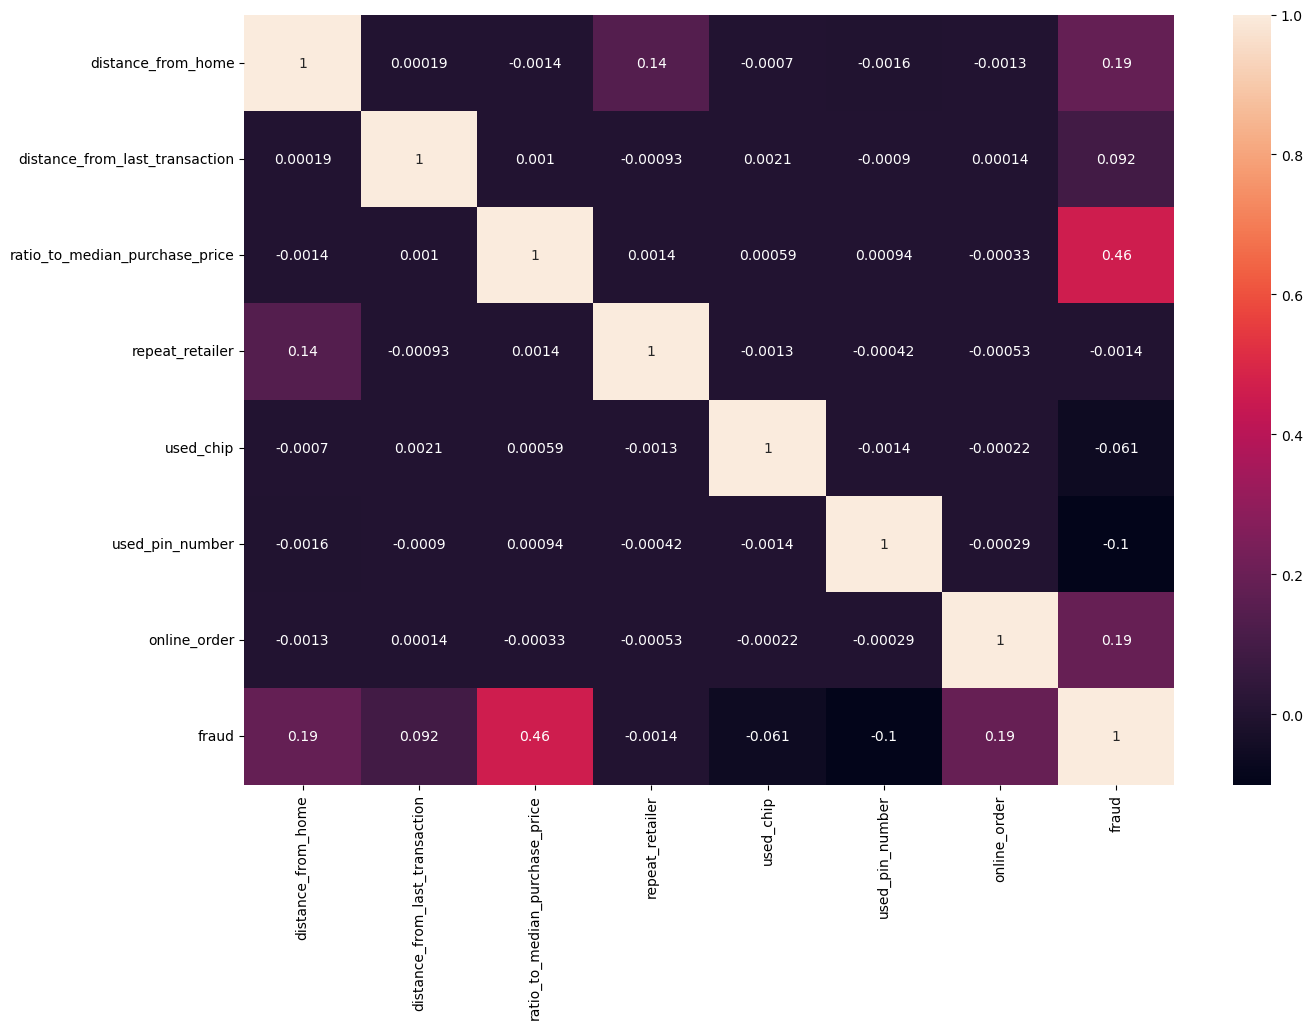

In [103]:
df_corr = df.corr()
sns.heatmap(df_corr, annot = True)